In [1]:
from mnist import MNIST 
import numpy as np

mndata = MNIST('./data')

mndata.load_training()
img_side = 28
n_mnist_pixels = img_side*img_side

In [2]:
labels = mndata.train_labels
# np.where(np.isin(labels,[2]))[0][0]
# np.where(labels == 1)
cluster_size = 10
train_inputs_idx = []
for idx in range(10):
    label_idx = np.where(np.isin(labels,[idx]))[0][:cluster_size]
    train_inputs_idx.append(label_idx)

samples_idx = np.array(train_inputs_idx, dtype='int').flatten()
samples_idx.size

100

In [145]:
layer_size = 10*4

I = np.zeros(n_mnist_pixels)
O = np.zeros(layer_size)
W = np.random.rand(O.size, I.size) * 0.001
print('W', W.shape, W.max(), W.min())

push_delta = 0.4
k = 1

syn_n = 2.0
lambda_LNR = 1.0

prec = 1e-30

syn_size = W.shape[1]
W_idx = np.arange(syn_size)
W_len = np.abs(W_idx[np.newaxis].T - W_idx)
W_len = (np.array(W_len, dtype='float') + 1) ** -syn_n

epoch_cnt = 100
# i_idx = 10
eps0 = 0.02

RFI_l = []

WT = np.expand_dims(W, axis=1)
WW = np.abs(WT * W)
RFI = np.sum(WW, axis=2)

RFI_l.append(RFI)

for epoch_idx in range(epoch_cnt):
    eps = (epoch_cnt - epoch_idx) * eps0

    for i_idx in samples_idx:
        img = mndata.train_images[i_idx]

        # infer
        I = np.array(img) / 255
        O = np.dot(W, I)

        # train
        dW = I - (W * O[np.newaxis].T)
        wO = np.argsort(O)[::-1]
        O.fill(0)
        O[wO[0]] = 1
        O[wO[1:1+k]] = -push_delta
        dW *= O[np.newaxis].T
        dW *= eps

        # local synapse reinforcement
        dLNR = np.dot(W, W_len)
        dLNR = dLNR / np.max(np.abs(dLNR))
        # dLNR -= np.min(dLNR)
        # dLNR *= eps
        dW *= dLNR * lambda_LNR

        # update
        dW = dW / np.abs(np.max(dW))
        W += dW

    # norm
    nc = np.max(np.abs(W), axis=1)
    nc[nc < prec]= prec
    W = W / nc[np.newaxis].T

    # remove weak synapses
    # for nW in W:
    #     nW[np.where(np.abs(nW) < 1.0 * np.median(np.abs(nW)))] = 0
    # WTr_coef = 10 * eps0 * (epoch_idx + 1)
    WTr_coef = 1e-10
    WTr = WTr_coef * np.mean(np.abs(W), axis=1)
    W[np.where(np.abs(W) < WTr[np.newaxis].T)] = 0

    if epoch_idx == 1 or epoch_idx == (epoch_cnt - 1):
        # receptive fields intersection
        WT = np.expand_dims(W, axis=1)
        WW = np.abs(WT - W)**2
        # RFI = np.array(np.sum(WW == 0, axis=2), dtype='float')
        RFI = np.sum(WW, axis=2)
        # RFI = np.max(RFI) - RFI
        # RFI = RFI / np.max(RFI, axis=1)

        RFI_l.append(RFI)

        print(W.size, np.sum(W == 0), np.sum(W != 0) / np.sum(W == 0))


W (40, 784) 0.0009999979472279069 2.936821893217978e-08
31360 970 31.329896907216494
31360 9988 2.139767721265519


In [146]:
for RFI in RFI_l:
    # rfi = 1 / np.exp(np.copy(RFI))
    rfi = np.copy(RFI)
    # rfi = W.shape[1] - rfi
    print(f'{rfi.max()=}')
    print(f'{rfi.min()=}')
    print(f'{np.median(rfi)=}')
    print(f'{np.mean(rfi)=}')
    print(f'{rfi.shape=}')
    print('_')


rfi.max()=0.00027982176825429485
rfi.min()=0.00017603575463388322
np.median(rfi)=0.0001950013448576506
np.mean(rfi)=0.00019636209468471767
rfi.shape=(40, 40)
_
rfi.max()=76.12464676912819
rfi.min()=0.0
np.median(rfi)=9.821848863805592
np.mean(rfi)=16.141316563670895
rfi.shape=(40, 40)
_
rfi.max()=87.96790477502412
rfi.min()=0.0
np.median(rfi)=13.949691269408206
np.mean(rfi)=16.931955945835508
rfi.shape=(40, 40)
_


816
644


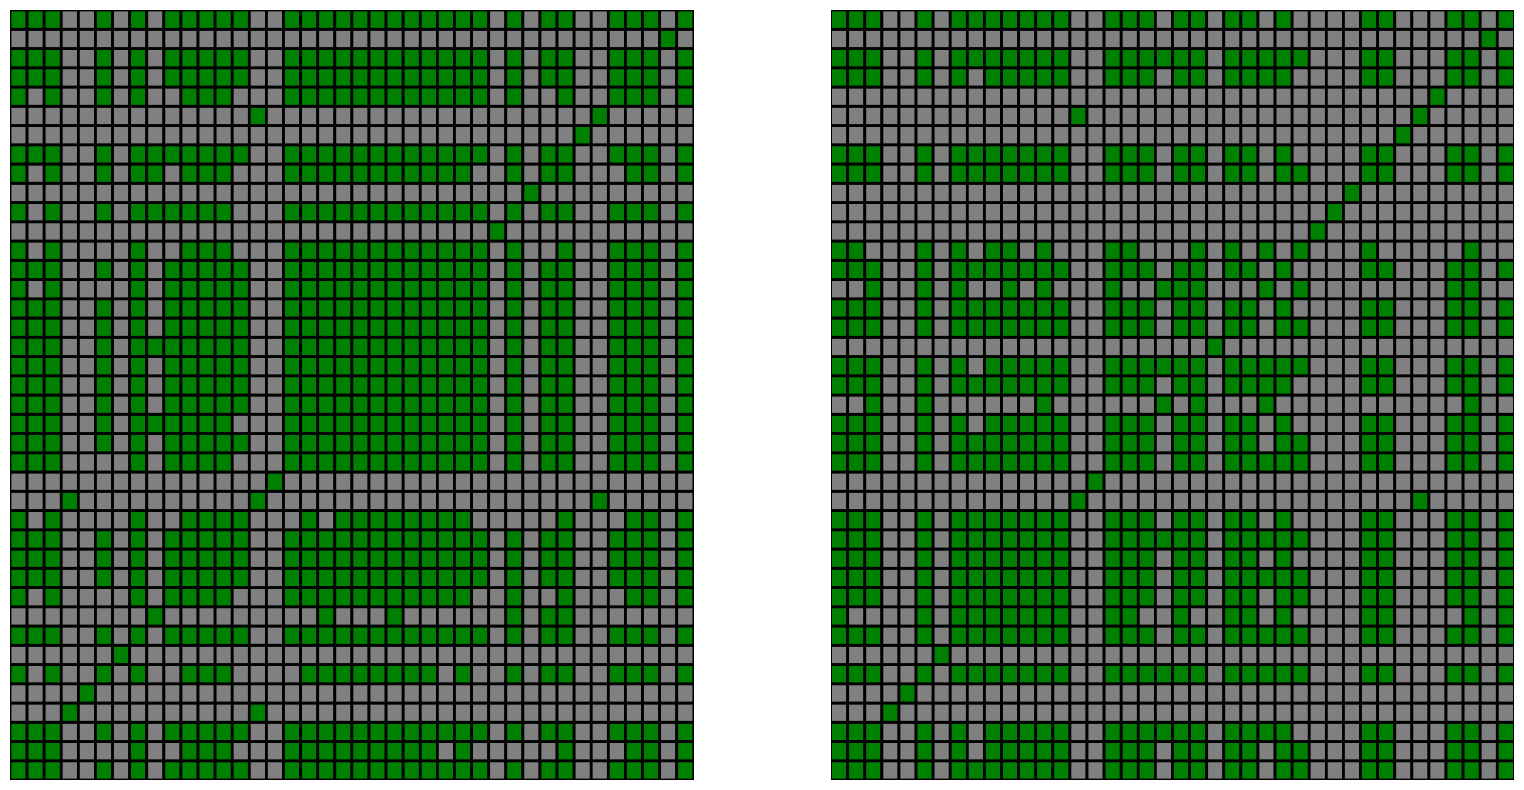

In [161]:
from pylab import *
from matplotlib import colors
%matplotlib inline

# for RFI in RFI_l:
#     print(RFI.max())
#     print(RFI.min())
#     print(np.median(RFI_l))
#     print('_')

size = 10
figure(figsize=(len(RFI_l) * size, 1* size))
cmap = colors.ListedColormap(['grey','green'])

for RFI_idx in range(1, len(RFI_l)):
    rfi = np.copy(RFI_l[RFI_idx])
    rfi = np.max(rfi) - rfi

    tr = 1.1 * np.mean(rfi)
    # tr = 0.1
    rfi[np.where(rfi <= tr)] = 0
    rfi[np.where(rfi > tr)] = 1

    print(np.sum(rfi == 1))

    subplot(1, len(RFI_l), RFI_idx + 1)
    
    plt.pcolor(rfi, cmap=cmap, edgecolors='k', linewidths=2)
    # imshow(rfi, interpolation='none', aspect='auto', cmap='gray')
    axis("off")

show()


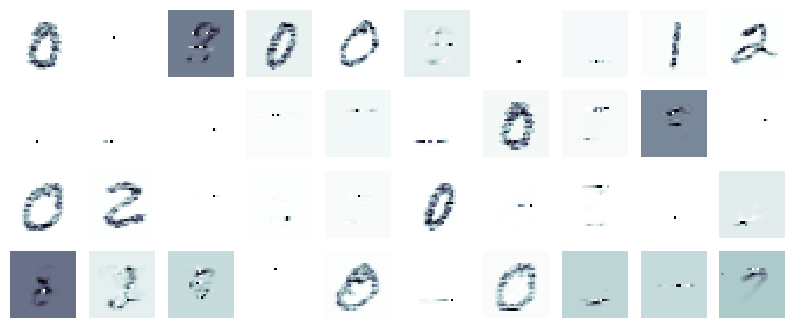

In [144]:
row_size = 10
col_size = int(layer_size / row_size)

figure(figsize=(row_size, col_size))

for col_idx in range(col_size):
    for row_idx in range(row_size):
        n_W_idx = col_idx * row_size + row_idx

        aimg = W[n_W_idx].reshape(img_side, img_side)

        subplot(col_size, row_size, n_W_idx + 1)

        imshow(aimg, interpolation='none', aspect='auto', cmap='bone')
        axis("off")

show()
